## Hard Stacking

In [7]:
import pandas as pd

csv_train = 'train.csv'
csv_test = 'test_nolabel.csv'
catboost_csv = 'catboost_ensemble.csv'
random_forest_csv = 'random_forest_ensemble.csv'
tree_csv = 'tree_ensemble.csv'
svm_csv = 'SVM_ensemble.csv'

df_train = pd.read_csv(csv_train)
df_test = pd.read_csv(csv_test)
df_catboost = pd.read_csv(catboost_csv)
df_random_forest = pd.read_csv(random_forest_csv)
df_tree = pd.read_csv(tree_csv)
df_svm = pd.read_csv(svm_csv)

In [8]:
train = pd.concat([df_train,
              df_catboost['Accept'].rename('CatBoost_Accept'),
              df_random_forest['Accept'].rename('RandomForest_Accept'),
              df_tree['Accept'].rename('Tree_Accept'),
              df_svm['Accept'].rename('SVM_Accept')], axis=1)

test = pd.concat([df_test,
              df_catboost['Accept'].rename('CatBoost_Accept'),
              df_random_forest['Accept'].rename('RandomForest_Accept'),
              df_tree['Accept'].rename('Tree_Accept'),
              df_svm['Accept'].rename('SVM_Accept')], axis=1)

Vamos a usar Catboost, se añade todo el codigo directamente (es lo mismo que en el otro IPYNB)

Fold 1: F1 = 0.8301
Fold 2: F1 = 0.8561
Fold 3: F1 = 0.8452
Fold 4: F1 = 0.8635
Fold 5: F1 = 0.8322
Fold 6: F1 = 0.8345
Fold 7: F1 = 0.8402


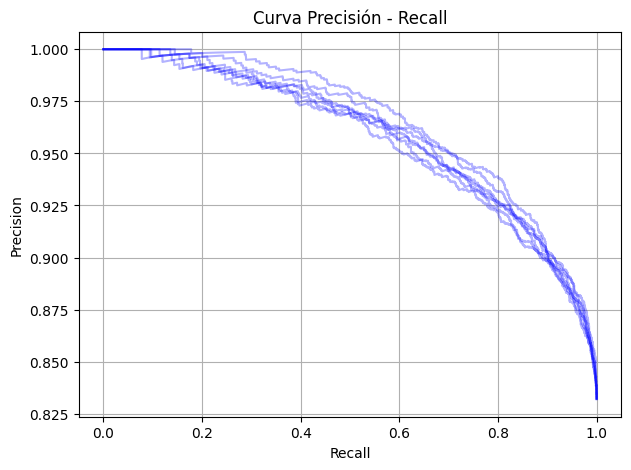


F1 promedio: 0.8431 (+/- 0.0117)


In [9]:
drop = ['LoanNr_ChkDgt', 'id', 'State']

train['ApprovalDate'] = pd.to_datetime(train['ApprovalDate'], format='%d-%b-%y')

train['NewExist'] = train['NewExist'].astype(str).replace({'0':'Unknown', '1':'New', '2':'Existing'})

train['FranchiseCode'] = train['FranchiseCode'].astype(str)
train['FranchiseCode'] = train['FranchiseCode'].apply(lambda x: 'No Franchise' if x in {'0', '1'} else 'Franchise')

train['UrbanRural'] = train['UrbanRural'].astype(str).replace({'0':'Unknown', '1':'Urban', '2':'Rural'})

train['RevLineCr'] = train['RevLineCr'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

train['LowDoc'] = train['LowDoc'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

train['DisbursementDate'] = pd.to_datetime(train['DisbursementDate'], format='%d-%b-%y')

train[['DisbursementGross', 'BalanceGross']] = train[['DisbursementGross', 'BalanceGross']].replace({r'\$': '', ',': ''}, regex=True).astype(float)


test['ApprovalDate'] = pd.to_datetime(test['ApprovalDate'], format='%d-%b-%y')

test['NewExist'] = test['NewExist'].astype(str).replace({'0':'Unknown', '1':'New', '2':'Existing'})

test['FranchiseCode'] = test['FranchiseCode'].astype(str)
test['FranchiseCode'] = test['FranchiseCode'].apply(lambda x: 'No Franchise' if x in {'0', '1'} else 'Franchise')

test['UrbanRural'] = test['UrbanRural'].astype(str).replace({'0':'Unknown', '1':'Urban', '2':'Rural'})

test['RevLineCr'] = test['RevLineCr'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

test['LowDoc'] = test['LowDoc'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

test['DisbursementDate'] = pd.to_datetime(test['DisbursementDate'], format='%d-%b-%y')

test[['DisbursementGross', 'BalanceGross']] = test[['DisbursementGross', 'BalanceGross']].replace({r'\$': '', ',': ''}, regex=True).astype(float)

train['ApprovalYear'] = train['ApprovalDate'].dt.year
train['ApprovalQuarter'] = train['ApprovalDate'].dt.quarter
train['DisbursementYear'] = train['DisbursementDate'].dt.year
train['DisbursementQuarter'] = train['DisbursementDate'].dt.quarter
train['DaysToDisbursement'] = (train['DisbursementDate'] - train['ApprovalDate']).dt.days

train = train.drop(columns=['ApprovalDate', 'DisbursementDate'])

test['ApprovalYear'] = test['ApprovalDate'].dt.year
test['ApprovalQuarter'] = test['ApprovalDate'].dt.quarter
test['DisbursementYear'] = test['DisbursementDate'].dt.year
test['DisbursementQuarter'] = test['DisbursementDate'].dt.quarter
test['DaysToDisbursement'] = (test['DisbursementDate'] - test['ApprovalDate']).dt.days

test = test.drop(columns=['ApprovalDate', 'DisbursementDate'])

import re
name_counts = train['Name'].value_counts()

def categorize_company(name):
    name = str(name).upper()
    if pd.isna(name):
        return "Other"
    name = name.upper().strip()
    
    if re.search(r'\b(CORP(ORATION)?|INC(ORPORATED)?|CO|COMPANY)\b', name):
        return "Corporation"
    elif re.search(r'\b(L\.?L\.?C\.?|LIMITED|LTD|L\.?T\.?D\.?)\b', name):
        return "Limited"
    elif re.search(r'\b(CHURCH|FOUNDATION|ASSOCIATION|NONPROFIT|CLUB)\b', name):
        return "NonProfit"
    elif re.search(r'\b(CITY|COUNTY|STATE|SCHOOL|UNIVERSITY|GOV(ERNMENT)?|BOARD)\b', name):
        return "Government"
    else:
        return "Other"
    
def refine_corporation(name):
    name = str(name).upper()
    if "CORP" in name:
        return "CORP"
    elif "INC" in name:
        return "INC"
    elif "CO" in name:
        return "CO"
    elif "COMPANY" in name:
        return "COMPANY"
    else:
        return "Other"
    
def refine_limited(name):
    name = str(name).upper()
    if "LLC" in name:
        return "LLC"
    elif "LTD" in name:
        return "LTD"
    elif "LIMITED" in name:
        return "LIMITED"
    else:
        return "Other"

train['CompanyType'] = train['Name'].apply(categorize_company)
train['CorpType'] = train.apply(lambda row: refine_corporation(row['Name']) if row['CompanyType'] == 'Corporation' else 'Not_Corp', axis=1)
train['LtdType'] = train.apply(lambda row: refine_limited(row['Name']) if row['CompanyType'] == 'Limited' else 'Not_Ltd', axis=1)

test['CompanyType'] = test['Name'].apply(categorize_company)
test['CorpType'] = test.apply(lambda row: refine_corporation(row['Name']) if row['CompanyType'] == 'Corporation' else 'Not_Corp', axis=1)
test['LtdType'] = test.apply(lambda row: refine_limited(row['Name']) if row['CompanyType'] == 'Limited' else 'Not_Ltd', axis=1)

# train = train.drop(columns='Name')
# test = test.drop(columns='Name')

contador_ciudades = train['City'].value_counts()
umbral = 60
otras = contador_ciudades[contador_ciudades < umbral].index
train['City'] = train['City'].replace(otras, 'OTHER_CITY')
test['City'] = test['City'].replace(otras, 'OTHER_CITY')

cat_features = train.select_dtypes(include=['object']).columns.tolist()
cat_features = list(set(cat_features) - set(drop))
for col in cat_features:
    train[col] = train[col].astype(str).fillna("Unknown")
    test[col] = test[col].astype(str).fillna("Unknown")

X = train.drop(drop + ['Accept'], axis=1)
y = train['Accept']

from collections import Counter

class_counts = Counter(y)
total = sum(class_counts.values())
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}
class_weights


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

f1_scores = []
models = []

plt.figure(figsize=(7,5))

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(
        iterations=800,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=5,
        eval_metric='F1',
        class_weights=[class_weights[0], class_weights[1]],
        random_state=42,
        cat_features=cat_features,
        verbose=False,
        early_stopping_rounds=125 ### CAMBIO IMPORTANTE
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    models.append(model)
    
    preds = model.predict(X_val)
    score = f1_score(y_val, preds)
    f1_scores.append(score)
    
    print(f'Fold {fold+1}: F1 = {score:.4f}')

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)

    plt.plot(recall, precision, color='blue', alpha=0.3)

plt.title(f"Curva Precisión - Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

print()
print(f'F1 promedio: {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})')

predictions_ensemble = np.array([model.predict(test.drop(drop, axis=1)) for model in models])
final_preds = [1 if np.sum(predictions_ensemble[:, i]) > (predictions_ensemble.shape[0] / 2) else 0 for i in range(predictions_ensemble.shape[1])]
submission = pd.DataFrame({
    'id': test['id'],
    'Accept': final_preds
})
submission.to_csv('stacking.csv', index=False)

## Soft Stacking

In [1]:
import pandas as pd

csv_train = 'train.csv'
csv_test = 'test_nolabel.csv'
catboost_csv = 'catboost_ensemble_proba.csv'
random_forest_csv = 'random_forest_ensemble_proba.csv'
tree_csv = 'tree_ensemble_proba.csv'
svm_csv = 'SVM_ensemble_proba.csv'

df_train = pd.read_csv(csv_train)
df_test = pd.read_csv(csv_test)
df_catboost = pd.read_csv(catboost_csv)
df_random_forest = pd.read_csv(random_forest_csv)
df_tree = pd.read_csv(tree_csv)
df_svm = pd.read_csv(svm_csv)

In [3]:
train = pd.concat([df_train,
              df_catboost['Accept_proba'].rename('CatBoost_Accept'),
              df_random_forest['Accept_proba'].rename('RandomForest_Accept'),
              df_tree['Accept_proba'].rename('Tree_Accept'),
              df_svm['Accept_proba'].rename('SVM_Accept')], axis=1)

test = pd.concat([df_test,
              df_catboost['Accept_proba'].rename('CatBoost_Accept'),
              df_random_forest['Accept_proba'].rename('RandomForest_Accept'),
              df_tree['Accept_proba'].rename('Tree_Accept'),
              df_svm['Accept_proba'].rename('SVM_Accept')], axis=1)

Fold 1: F1 = 0.8482
Fold 2: F1 = 0.8558
Fold 3: F1 = 0.8554
Fold 4: F1 = 0.8438
Fold 5: F1 = 0.8427
Fold 6: F1 = 0.8376
Fold 7: F1 = 0.8498


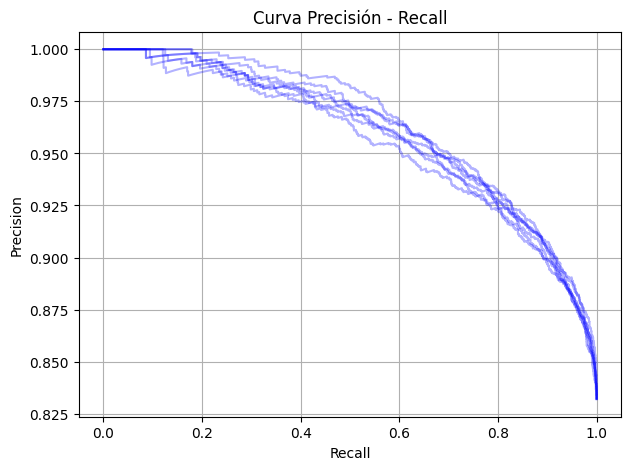


F1 promedio: 0.8476 (+/- 0.0062)


In [ ]:
drop = ['LoanNr_ChkDgt', 'id', 'State']

train['ApprovalDate'] = pd.to_datetime(train['ApprovalDate'], format='%d-%b-%y')

train['NewExist'] = train['NewExist'].astype(str).replace({'0':'Unknown', '1':'New', '2':'Existing'})

train['FranchiseCode'] = train['FranchiseCode'].astype(str)
train['FranchiseCode'] = train['FranchiseCode'].apply(lambda x: 'No Franchise' if x in {'0', '1'} else 'Franchise')

train['UrbanRural'] = train['UrbanRural'].astype(str).replace({'0':'Unknown', '1':'Urban', '2':'Rural'})

train['RevLineCr'] = train['RevLineCr'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

train['LowDoc'] = train['LowDoc'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

train['DisbursementDate'] = pd.to_datetime(train['DisbursementDate'], format='%d-%b-%y')

train[['DisbursementGross', 'BalanceGross']] = train[['DisbursementGross', 'BalanceGross']].replace({r'\$': '', ',': ''}, regex=True).astype(float)


test['ApprovalDate'] = pd.to_datetime(test['ApprovalDate'], format='%d-%b-%y')

test['NewExist'] = test['NewExist'].astype(str).replace({'0':'Unknown', '1':'New', '2':'Existing'})

test['FranchiseCode'] = test['FranchiseCode'].astype(str)
test['FranchiseCode'] = test['FranchiseCode'].apply(lambda x: 'No Franchise' if x in {'0', '1'} else 'Franchise')

test['UrbanRural'] = test['UrbanRural'].astype(str).replace({'0':'Unknown', '1':'Urban', '2':'Rural'})

test['RevLineCr'] = test['RevLineCr'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

test['LowDoc'] = test['LowDoc'].replace({'N':'No', 'Y':'Yes'}).apply(lambda x: 'Unknown' if x not in {'Yes', 'No'} else x)

test['DisbursementDate'] = pd.to_datetime(test['DisbursementDate'], format='%d-%b-%y')

test[['DisbursementGross', 'BalanceGross']] = test[['DisbursementGross', 'BalanceGross']].replace({r'\$': '', ',': ''}, regex=True).astype(float)

train['ApprovalYear'] = train['ApprovalDate'].dt.year
train['ApprovalQuarter'] = train['ApprovalDate'].dt.quarter
train['DisbursementYear'] = train['DisbursementDate'].dt.year
train['DisbursementQuarter'] = train['DisbursementDate'].dt.quarter
train['DaysToDisbursement'] = (train['DisbursementDate'] - train['ApprovalDate']).dt.days

train = train.drop(columns=['ApprovalDate', 'DisbursementDate'])

test['ApprovalYear'] = test['ApprovalDate'].dt.year
test['ApprovalQuarter'] = test['ApprovalDate'].dt.quarter
test['DisbursementYear'] = test['DisbursementDate'].dt.year
test['DisbursementQuarter'] = test['DisbursementDate'].dt.quarter
test['DaysToDisbursement'] = (test['DisbursementDate'] - test['ApprovalDate']).dt.days

test = test.drop(columns=['ApprovalDate', 'DisbursementDate'])

import re
name_counts = train['Name'].value_counts()

def categorize_company(name):
    name = str(name).upper()
    if pd.isna(name):
        return "Other"
    name = name.upper().strip()
    
    if re.search(r'\b(CORP(ORATION)?|INC(ORPORATED)?|CO|COMPANY)\b', name):
        return "Corporation"
    elif re.search(r'\b(L\.?L\.?C\.?|LIMITED|LTD|L\.?T\.?D\.?)\b', name):
        return "Limited"
    elif re.search(r'\b(CHURCH|FOUNDATION|ASSOCIATION|NONPROFIT|CLUB)\b', name):
        return "NonProfit"
    elif re.search(r'\b(CITY|COUNTY|STATE|SCHOOL|UNIVERSITY|GOV(ERNMENT)?|BOARD)\b', name):
        return "Government"
    else:
        return "Other"
    
def refine_corporation(name):
    name = str(name).upper()
    if "CORP" in name:
        return "CORP"
    elif "INC" in name:
        return "INC"
    elif "CO" in name:
        return "CO"
    elif "COMPANY" in name:
        return "COMPANY"
    else:
        return "Other"
    
def refine_limited(name):
    name = str(name).upper()
    if "LLC" in name:
        return "LLC"
    elif "LTD" in name:
        return "LTD"
    elif "LIMITED" in name:
        return "LIMITED"
    else:
        return "Other"

train['CompanyType'] = train['Name'].apply(categorize_company)
train['CorpType'] = train.apply(lambda row: refine_corporation(row['Name']) if row['CompanyType'] == 'Corporation' else 'Not_Corp', axis=1)
train['LtdType'] = train.apply(lambda row: refine_limited(row['Name']) if row['CompanyType'] == 'Limited' else 'Not_Ltd', axis=1)

test['CompanyType'] = test['Name'].apply(categorize_company)
test['CorpType'] = test.apply(lambda row: refine_corporation(row['Name']) if row['CompanyType'] == 'Corporation' else 'Not_Corp', axis=1)
test['LtdType'] = test.apply(lambda row: refine_limited(row['Name']) if row['CompanyType'] == 'Limited' else 'Not_Ltd', axis=1)

# train = train.drop(columns='Name')
# test = test.drop(columns='Name')

contador_ciudades = train['City'].value_counts()
umbral = 60
otras = contador_ciudades[contador_ciudades < umbral].index
train['City'] = train['City'].replace(otras, 'OTHER_CITY')
test['City'] = test['City'].replace(otras, 'OTHER_CITY')

cat_features = train.select_dtypes(include=['object']).columns.tolist()
cat_features = list(set(cat_features) - set(drop))
for col in cat_features:
    train[col] = train[col].astype(str).fillna("Unknown")
    test[col] = test[col].astype(str).fillna("Unknown")

X = train.drop(drop + ['Accept'], axis=1)
y = train['Accept']

from collections import Counter

class_counts = Counter(y)
total = sum(class_counts.values())
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}
class_weights


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

f1_scores = []
models = []

plt.figure(figsize=(7,5))

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(
        iterations=800,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=5,
        eval_metric='F1',
        class_weights=[class_weights[0], class_weights[1]],
        random_state=42,
        cat_features=cat_features,
        verbose=False,
        early_stopping_rounds=125 ### CAMBIO IMPORTANTE
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    models.append(model)
    
    preds = model.predict(X_val)
    score = f1_score(y_val, preds)
    f1_scores.append(score)
    
    print(f'Fold {fold+1}: F1 = {score:.4f}')

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)

    plt.plot(recall, precision, color='blue', alpha=0.3)

plt.title(f"Curva Precisión - Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

print()
print(f'F1 promedio: {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})')

probabilities_ensemble = np.array([model.predict_proba(test.drop(drop, axis=1))[:, 1] for model in models])
mean_probabilities = np.mean(probabilities_ensemble, axis=0)
final_preds_soft = (mean_probabilities > 0.5).astype(int)

submission = pd.DataFrame({
    'id': test['id'],
    'Accept': final_preds_soft
})
submission.to_csv('stacking_soft.csv', index=False)